In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('myproj').getOrCreate()
data = data = spark.table('fetal_health')
data.printSchema()

root
 |-- baseline value: double (nullable = true)
 |-- accelerations: double (nullable = true)
 |-- fetal_movement: double (nullable = true)
 |-- uterine_contractions: double (nullable = true)
 |-- light_decelerations: double (nullable = true)
 |-- severe_decelerations: double (nullable = true)
 |-- prolongued_decelerations: double (nullable = true)
 |-- abnormal_short_term_variability: double (nullable = true)
 |-- mean_value_of_short_term_variability: double (nullable = true)
 |-- percentage_of_time_with_abnormal_long_term_variability: double (nullable = true)
 |-- mean_value_of_long_term_variability: double (nullable = true)
 |-- histogram_width: double (nullable = true)
 |-- histogram_min: double (nullable = true)
 |-- histogram_max: double (nullable = true)
 |-- histogram_number_of_peaks: double (nullable = true)
 |-- histogram_number_of_zeroes: double (nullable = true)
 |-- histogram_mode: double (nullable = true)
 |-- histogram_mean: double (nullable = true)
 |-- histogram_medi

In [0]:
from pyspark.sql.functions import col
data = data.withColumn("fetal_health", col("fetal_health").cast("integer"))


In [0]:
from pyspark.sql.functions import count
# Group the DataFrame by the "class" column and count the number of observations in each group
class_counts = data.groupBy("fetal_health").agg(count("*").alias("count"))

# Show the results
class_counts.show()

+------------+-----+
|fetal_health|count|
+------------+-----+
|           1| 1655|
|           3|  176|
|           2|  295|
+------------+-----+



In [0]:
data.createOrReplaceTempView("df")
# Run a SQL query to select the first 5 rows
first_five_rows = spark.sql("SELECT * FROM df LIMIT 5")
display(first_five_rows)


baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
120.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2
132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1
133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1
134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1
132.0,0.007,0.0,0.008,0.0,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1


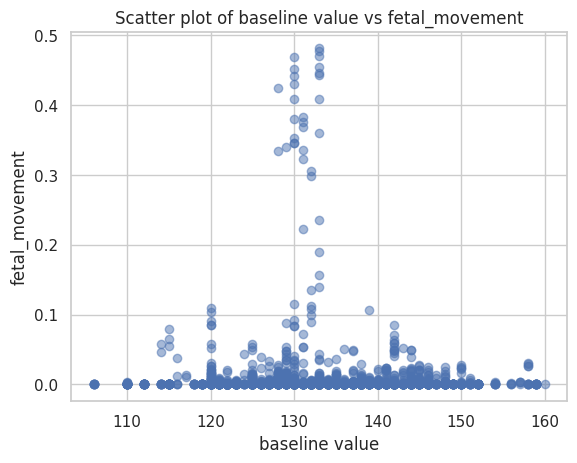

In [0]:
import matplotlib.pyplot as plt
x_col = "baseline value"
y_col = "fetal_movement"
# Convert to Pandas DataFrame
pandas_df = data.select(col(x_col), col(y_col)).toPandas()

# Create a scatter plot using Matplotlib
plt.scatter(pandas_df[x_col], pandas_df[y_col], alpha=0.5)
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title("Scatter plot of {} vs {}".format(x_col, y_col))
plt.show()

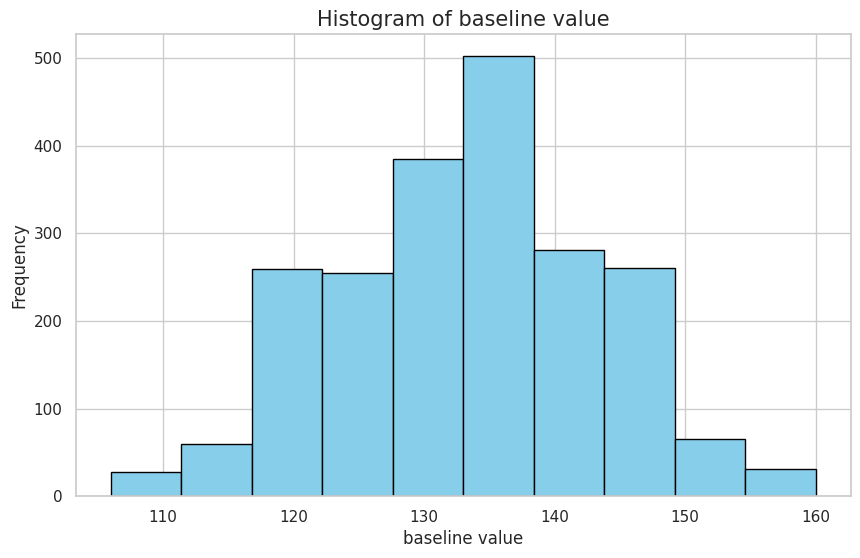

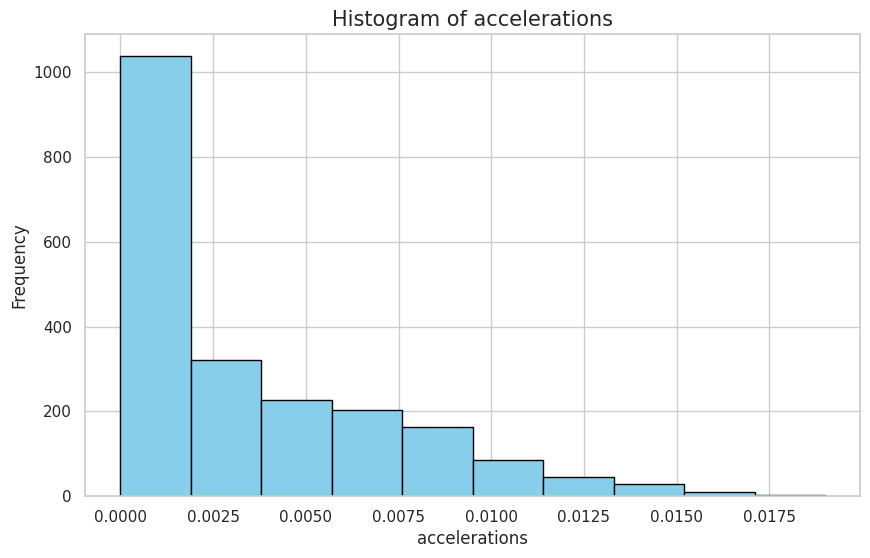

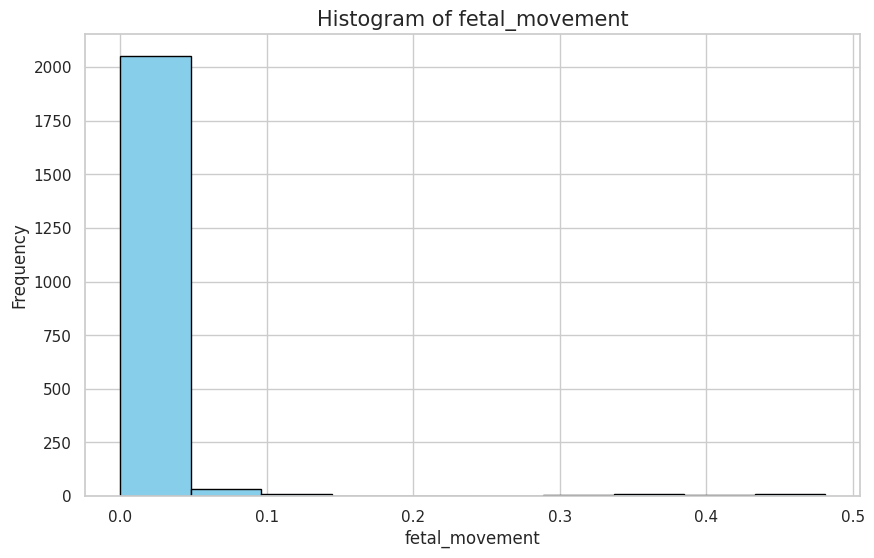

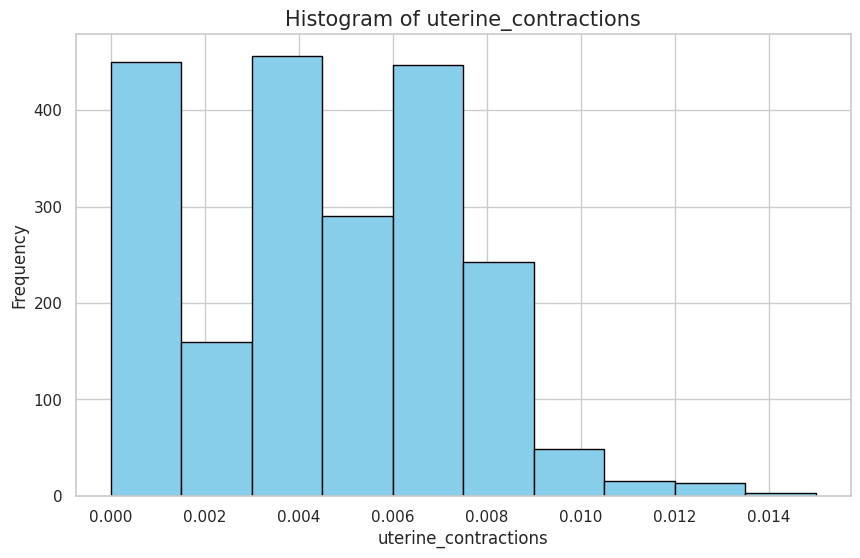

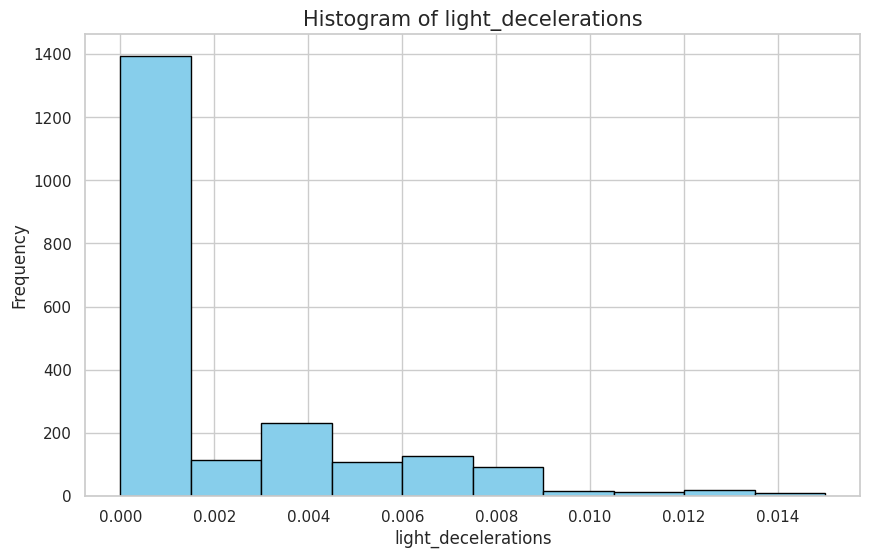

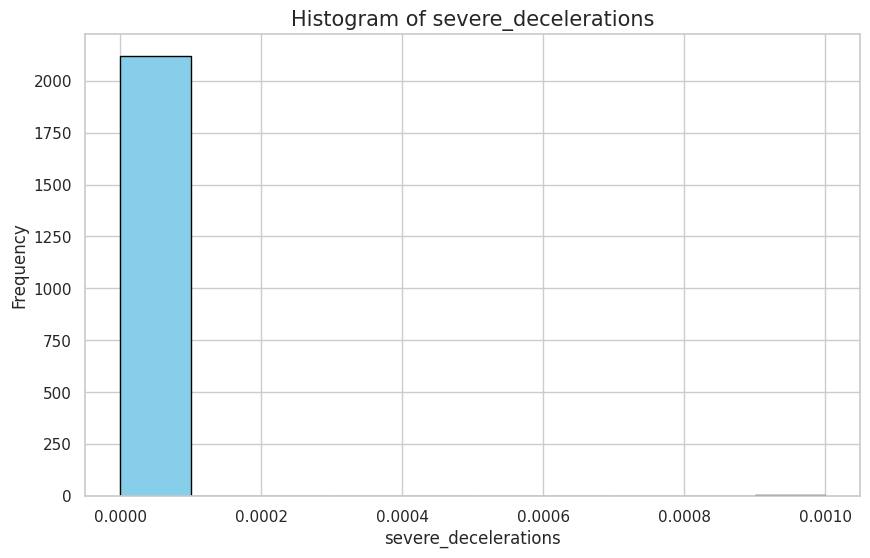

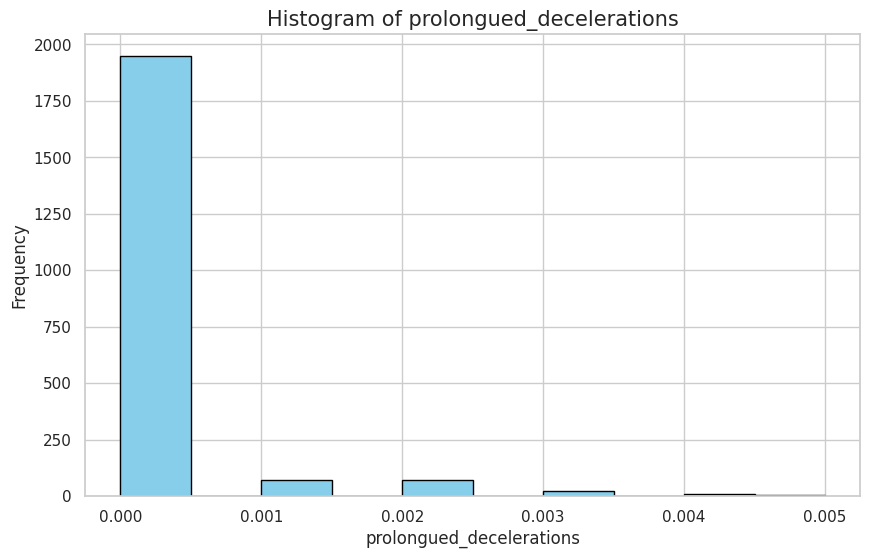

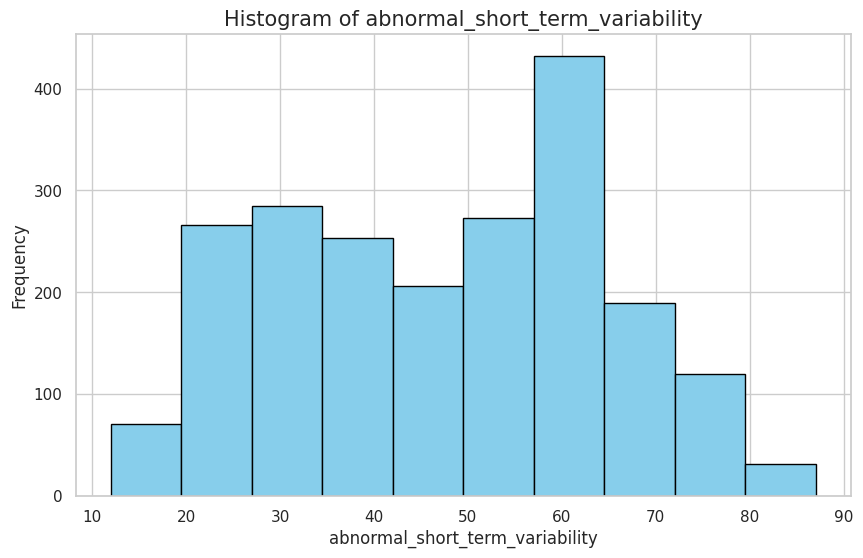

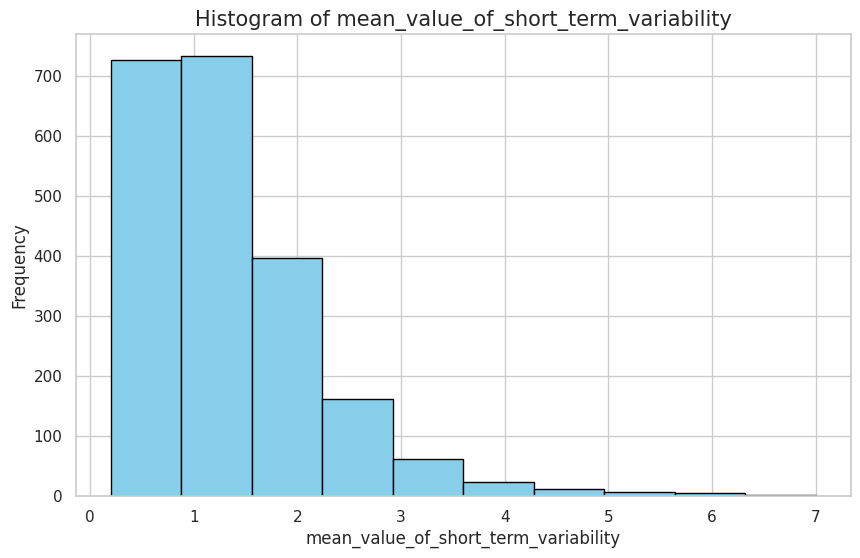

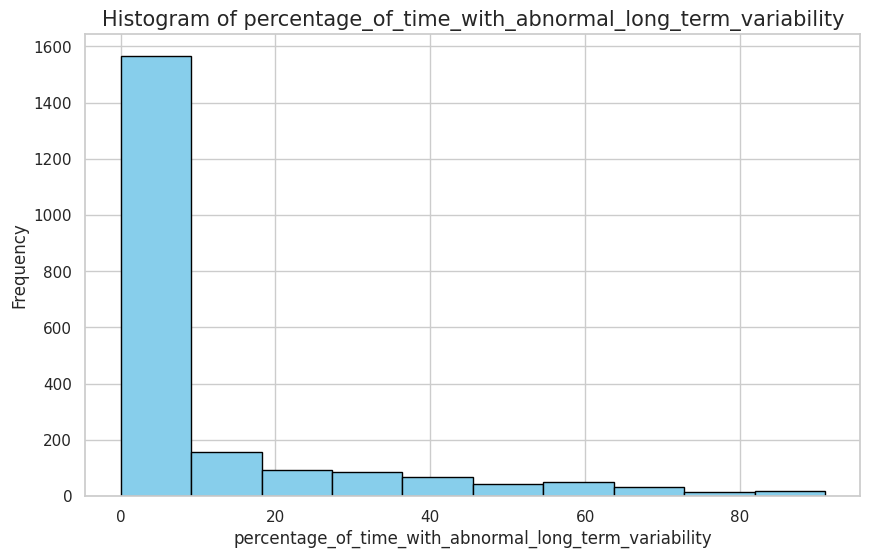

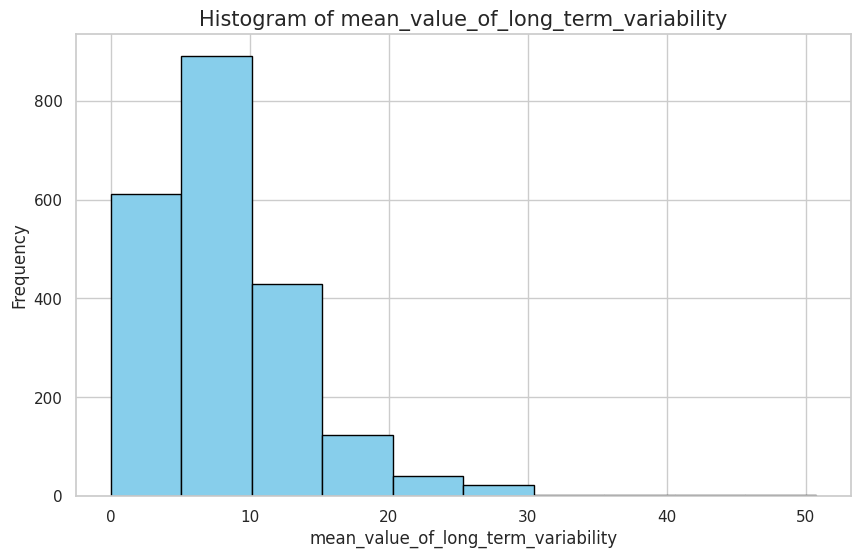

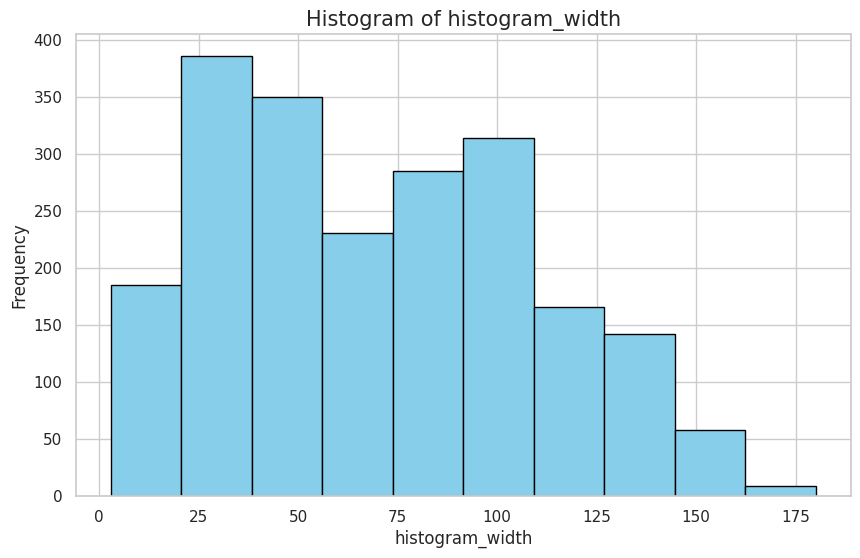

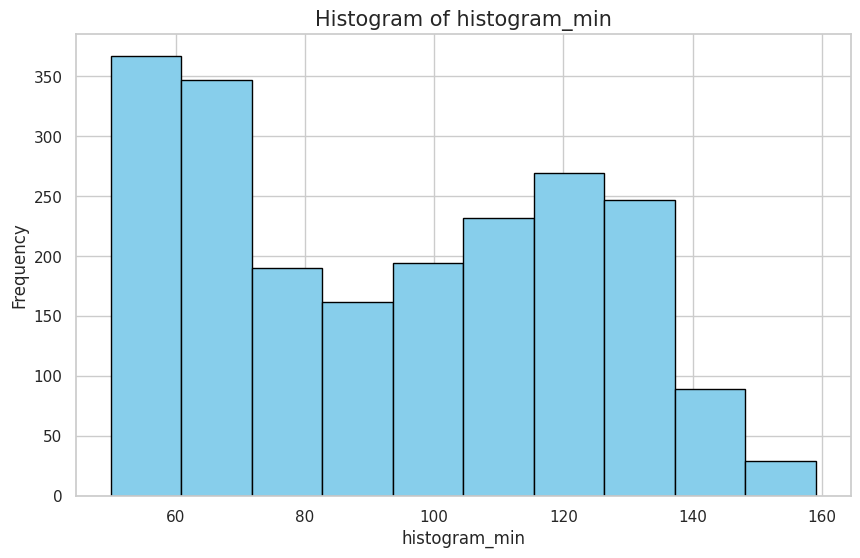

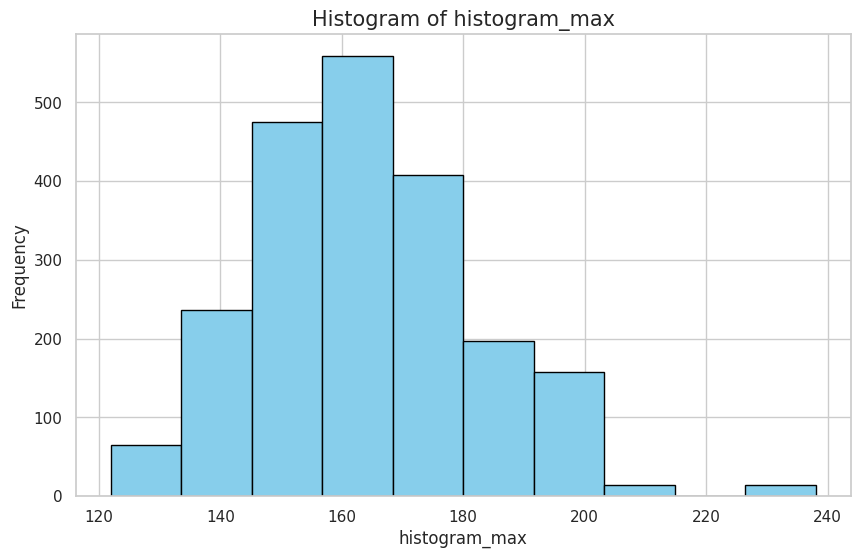

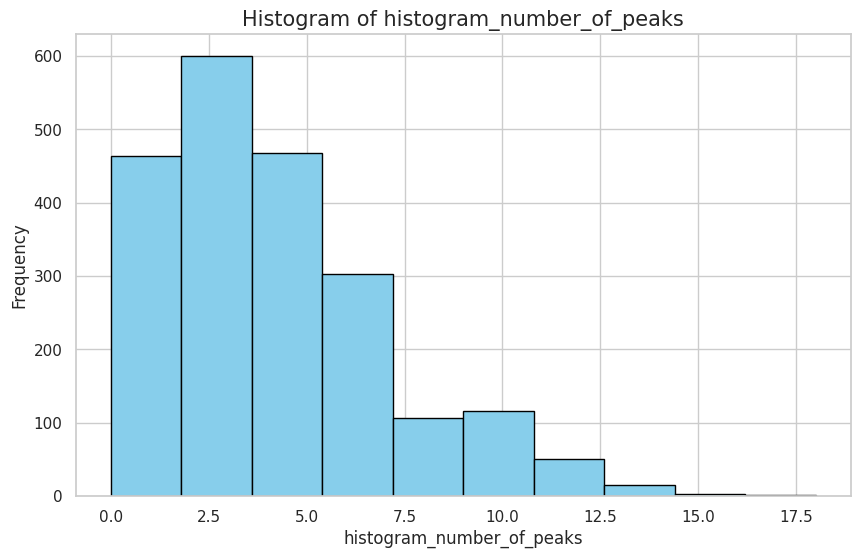

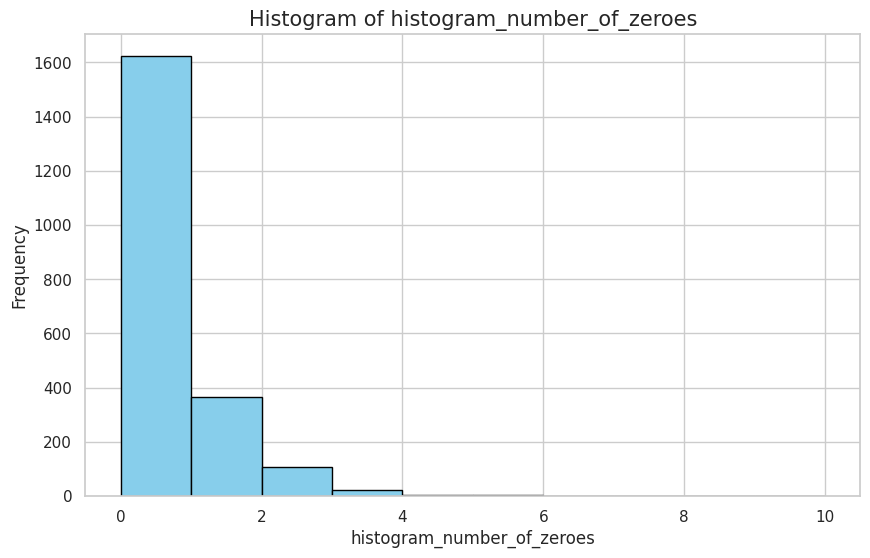

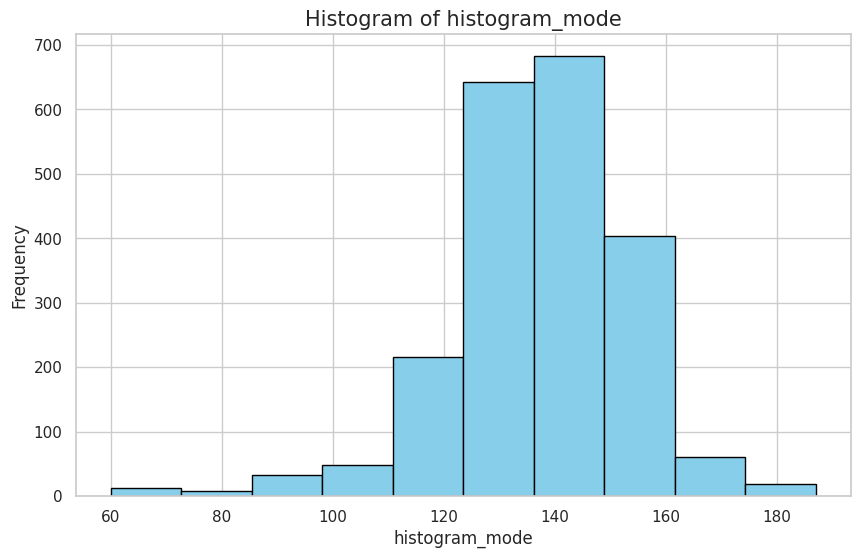

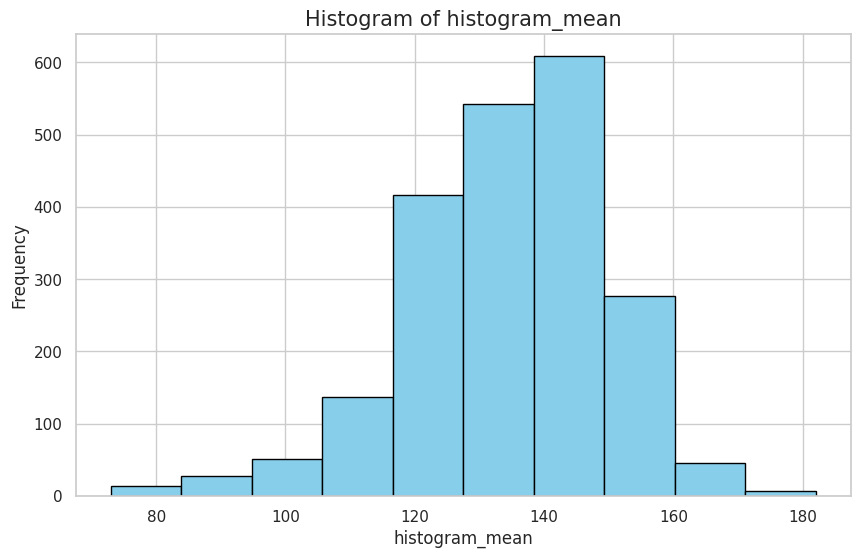

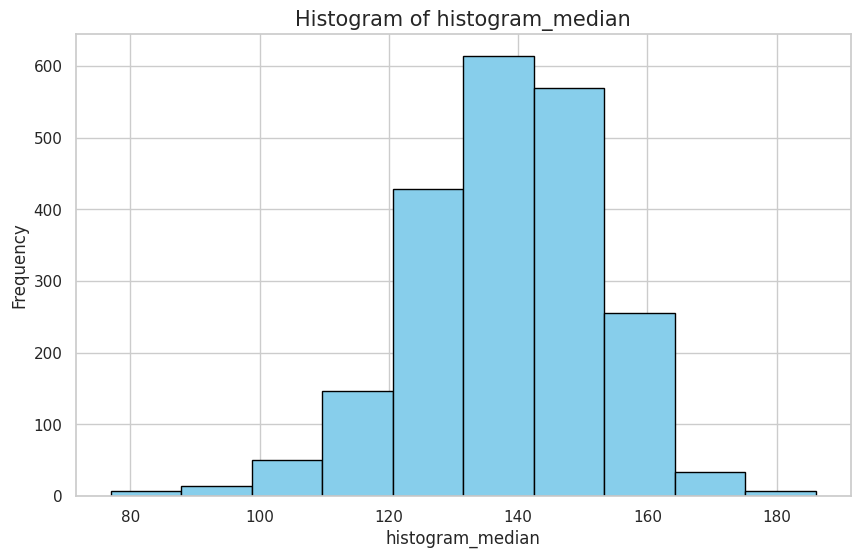

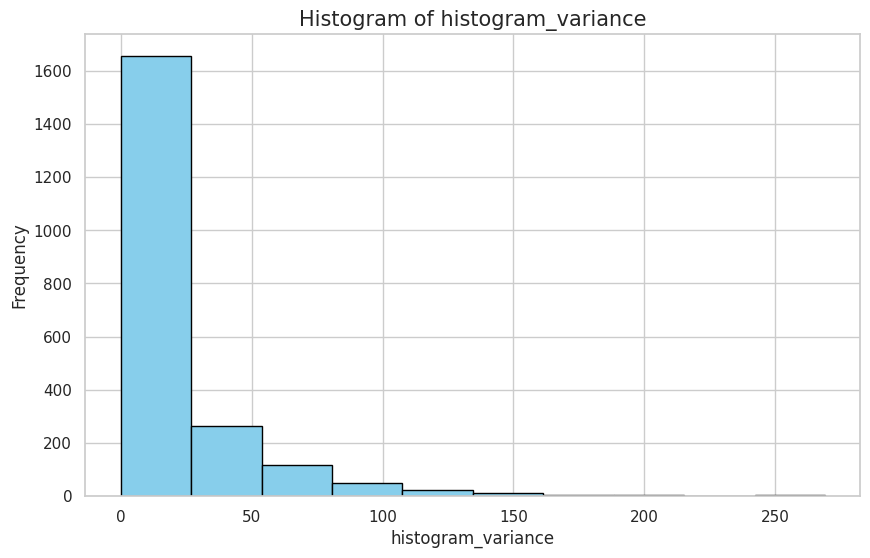

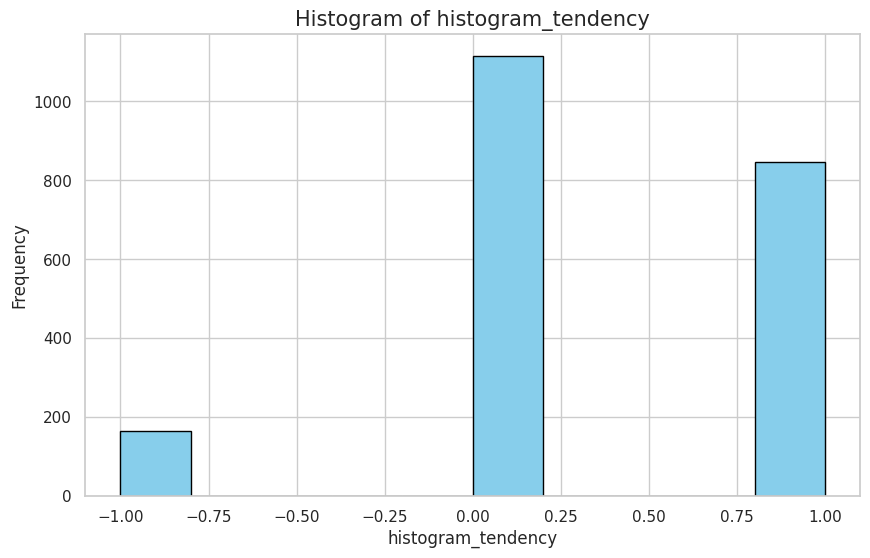

In [0]:
import seaborn as sns
import pyspark.sql.functions as F
import numpy as np

sns.set(style="whitegrid")
for col in data.columns:
    if col != "fetal_health":
        values = data.select(col).rdd.flatMap(lambda x: x).collect()
        plt.figure(figsize=(10, 6))  
        plt.hist(values, color='skyblue', edgecolor='black')
        plt.title(f'Histogram of {col}', fontsize=15)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)

        plt.show()

        import matplotlib.pyplot as plt
import pyspark.sql.functions as F



In [0]:
from pyspark.sql.functions import rand
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.classification import MultilayerPerceptronClassifier


df = data

# Convert label column to DoubleType
df = df.withColumn("fetal_health", df["fetal_health"].cast(DoubleType()))

# Split the data into training and test sets
(trainingData, testData) = df.randomSplit([0.8, 0.2], seed=42)

# Undersample the majority class in the training data
majority_class = trainingData.filter(trainingData["fetal_health"] == 1)
minority_class = trainingData.filter(trainingData["fetal_health"] == 3)
undersampled_majority_class = majority_class.sample(False, minority_class.count() / majority_class.count()).orderBy(rand())
undersampled_trainingData = minority_class.union(undersampled_majority_class)

# Assemble features into a vector
cols = df.columns
assembler = VectorAssembler(inputCols=cols[:-1], outputCol="features")

# Define models
dt = DecisionTreeClassifier(labelCol="fetal_health", featuresCol="features")
rf = RandomForestClassifier(labelCol="fetal_health", featuresCol="features", numTrees=10)

# Define pipeline for each model
dt_pipeline = Pipeline(stages=[assembler, dt])
rf_pipeline = Pipeline(stages=[assembler, rf])

# Train the models on the undersampled training data
dt_model = dt_pipeline.fit(undersampled_trainingData)
rf_model = rf_pipeline.fit(undersampled_trainingData)

# Make predictions on the test data
dt_predictions = dt_model.transform(testData)
rf_predictions = rf_model.transform(testData)

# Evaluate the accuracy of the models
evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="accuracy")
dt_accuracy = evaluator.evaluate(dt_predictions)
rf_accuracy = evaluator.evaluate(rf_predictions)

# Print the accuracy of each model
print("Decision Tree Accuracy = %g" % (dt_accuracy))
print("Random Forest Accuracy = %g" % (rf_accuracy))



Decision Tree Accuracy = 0.797872
Random Forest Accuracy = 0.827128


In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create a MulticlassClassificationEvaluator object
evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="f1")

# Compute the F1 score
f1_score = evaluator.evaluate(rf_predictions)
print("F1 score = {:.2f}".format(f1_score))

# Compute the recall
evaluator.setMetricName("weightedRecall")
recall = evaluator.evaluate(rf_predictions)
print("Recall = {:.2f}".format(recall))

# Compute the precision
evaluator.setMetricName("weightedPrecision")
precision = evaluator.evaluate(rf_predictions)
print("Precision = {:.2f}".format(precision))


F1 score = 0.77
Recall = 0.83
Precision = 0.73


### Test oversampling

In [0]:
# Oversample the minority class in the training data
majority_class = trainingData.filter(trainingData["fetal_health"] == 1)
minority_class = trainingData.filter(trainingData["fetal_health"] == 3)

oversampled_minority_class = minority_class.sample(True, majority_class.count() / minority_class.count(), seed=42)

oversampled_trainingData = majority_class.union(oversampled_minority_class)

# Define models
dt = DecisionTreeClassifier(labelCol="fetal_health", featuresCol="features")
rf = RandomForestClassifier(labelCol="fetal_health", featuresCol="features", numTrees=10)

# Define pipeline for each model
dt_pipeline = Pipeline(stages=[assembler, dt])
rf_pipeline = Pipeline(stages=[assembler, rf])

# Train the models on the oversampled training data
dt_model = dt_pipeline.fit(oversampled_trainingData)
rf_model = rf_pipeline.fit(oversampled_trainingData)

# Make predictions on the test data
dt_predictions = dt_model.transform(testData)
rf_predictions = rf_model.transform(testData)

# Evaluate the accuracy of the models
evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="accuracy")
dt_accuracy = evaluator.evaluate(dt_predictions)
rf_accuracy = evaluator.evaluate(rf_predictions)

# Print the accuracy of each model
print("Decision Tree Accuracy = %g" % (dt_accuracy))
print("Random Forest Accuracy = %g" % (rf_accuracy))


Decision Tree Accuracy = 0.819149
Random Forest Accuracy = 0.821809


In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create a MulticlassClassificationEvaluator object
evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="f1")

# Compute the F1 score
f1_score = evaluator.evaluate(dt_predictions)
print("F1 score = {:.2f}".format(f1_score))

# Compute the recall
evaluator.setMetricName("weightedRecall")
recall = evaluator.evaluate(dt_predictions)
print("Recall = {:.2f}".format(recall))

# Compute the precision
evaluator.setMetricName("weightedPrecision")
precision = evaluator.evaluate(dt_predictions)
print("Precision = {:.2f}".format(precision))


F1 score = 0.77
Recall = 0.82
Precision = 0.75


### Test random sampling

In [0]:
# define models
dt = DecisionTreeClassifier(labelCol="fetal_health", featuresCol="features")
rf = RandomForestClassifier(labelCol="fetal_health", featuresCol="features")


# define pipeline for each model
dt_pipeline = Pipeline(stages=[assembler, dt])
rf_pipeline = Pipeline(stages=[assembler, rf])

# train the models on the training data
dt_model = dt_pipeline.fit(trainingData)
rf_model = rf_pipeline.fit(trainingData)

# make predictions on the test data
dt_predictions = dt_model.transform(testData)
rf_predictions = rf_model.transform(testData)

# evaluate the accuracy of the models
evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="accuracy")
dt_accuracy = evaluator.evaluate(dt_predictions)
rf_accuracy = evaluator.evaluate(rf_predictions)

# print the accuracy of each model
print("Decision Tree Accuracy = %g" % (dt_accuracy))
print("Random Forest Accuracy = %g" % (rf_accuracy))


Decision Tree Accuracy = 0.928191
Random Forest Accuracy = 0.917553


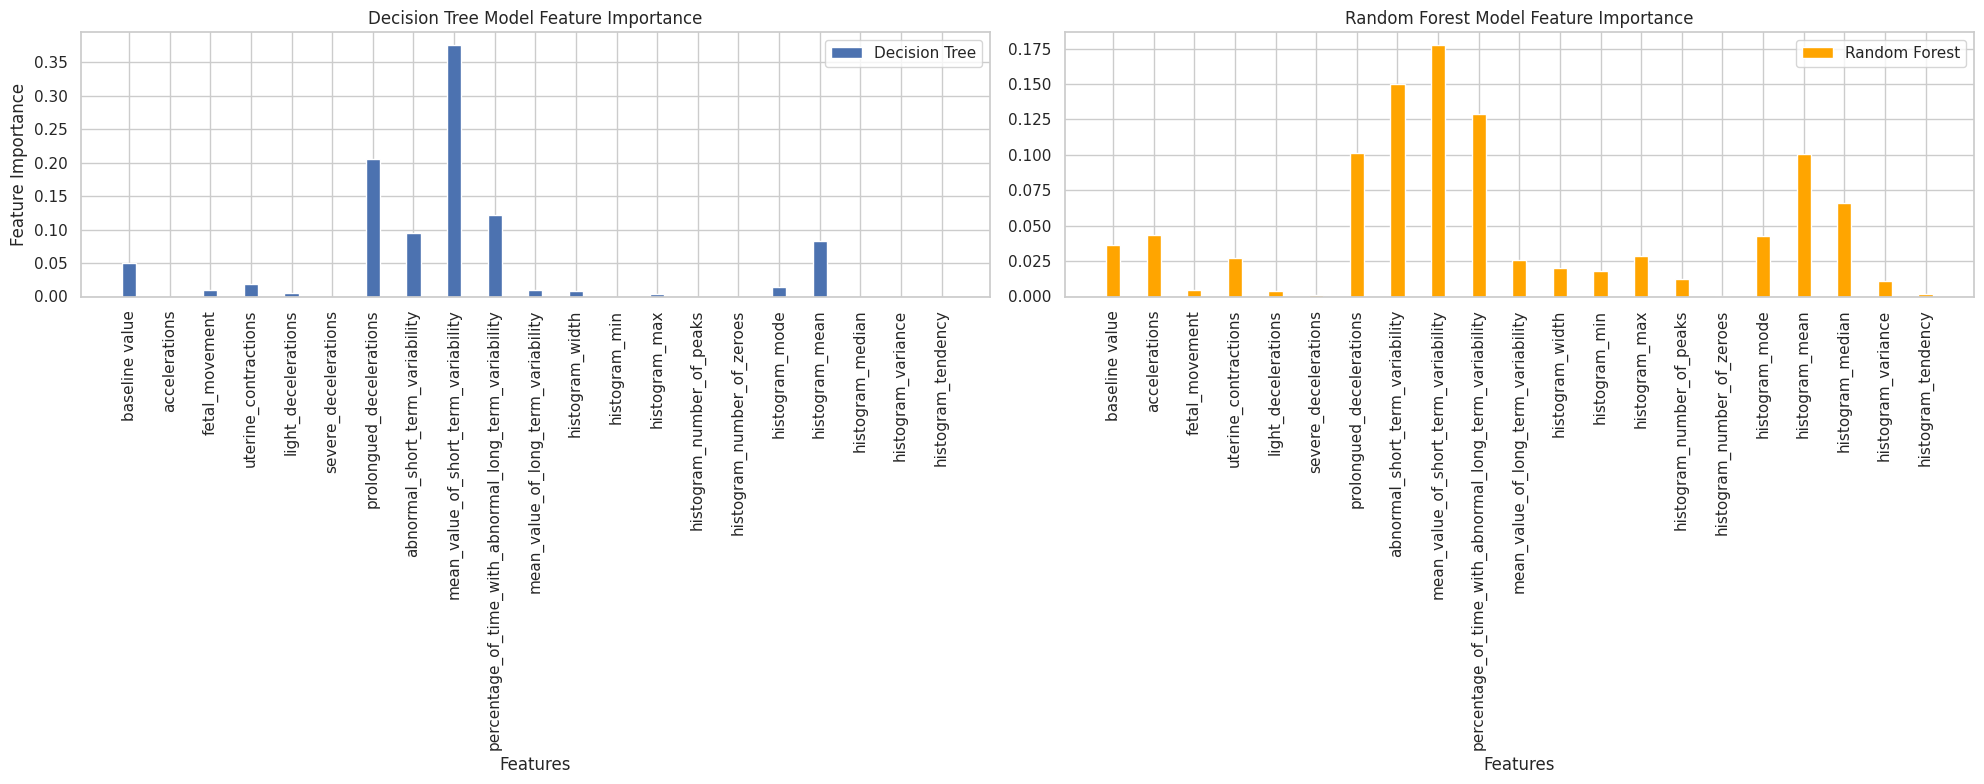

In [0]:

# Assuming 'cols' is a list of feature names and 'dt_model' and 'rf_model' have been previously defined and trained
# Extract feature importance for decision tree model
dt_feature_importance = dt_model.stages[-1].featureImportances.toArray()

# Extract feature importance for random forest model
rf_feature_importance = rf_model.stages[-1].featureImportances.toArray()

# Define the width of the bars so they don't overlap
bar_width = 0.35
# Set position of bar on X axis
r1 = np.arange(len(dt_feature_importance))
r2 = [x + bar_width for x in r1]

# Create a bar chart for feature importance
fig, axs = plt.subplots(1, 2, figsize=(20, 8))  # Adjust the figure size as needed

# Plot for decision tree feature importance
axs[0].bar(r1, dt_feature_importance, width=bar_width, label='Decision Tree')
axs[0].set_xticks([x for x in range(len(cols[:-1]))])
axs[0].set_xticklabels(cols[:-1], rotation=90)
axs[0].set_xlabel('Features')
axs[0].set_ylabel('Feature Importance')
axs[0].set_title('Decision Tree Model Feature Importance')
axs[0].legend()

# Plot for random forest feature importance
axs[1].bar(r2, rf_feature_importance, width=bar_width, color='orange', label='Random Forest')
axs[1].set_xticks([x + bar_width for x in range(len(cols[:-1]))])
axs[1].set_xticklabels(cols[:-1], rotation=90)
axs[1].set_xlabel('Features')
axs[1].set_title('Random Forest Model Feature Importance')
axs[1].legend()

# Show the plot
plt.tight_layout()
plt.show()


In [0]:
# evaluate the model on the test data for DT
predictions = dt_predictions
auc = evaluator.evaluate(predictions)
print("AUC:", auc)

AUC: 0.9281914893617021


In [0]:
# evaluate the model on the test data for RF
predictions = rf_predictions
auc = evaluator.evaluate(predictions)
print("AUC:", auc)

AUC: 0.9175531914893617


In [0]:
# evaluate the F1 of the models
evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="f1")
dt_f1 = evaluator.evaluate(dt_predictions)
rf_f1 = evaluator.evaluate(rf_predictions)
print("Decision Tree F1 = %g" % (dt_f1))
print("Random Forest F1 = %g" % (rf_f1))

Decision Tree F1 = 0.926502
Random Forest F1 = 0.914092


In [0]:
# evaluate the weightedPrecision of the models
evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="weightedPrecision")
dt_weightedPrecision = evaluator.evaluate(dt_predictions)
rf_weightedPrecision = evaluator.evaluate(rf_predictions)
# print the Precision of each model
print("Decision Tree Precision = %g" % (dt_weightedPrecision))
print("Random Forest Precision = %g" % (rf_weightedPrecision))

Decision Tree Precision = 0.925894
Random Forest Precision = 0.916235


In [0]:
# evaluate the weightedFMeasure of the models
evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="weightedFMeasure")
dt_weightedFMeasure = evaluator.evaluate(dt_predictions)
rf_weightedFMeasure = evaluator.evaluate(rf_predictions)
# print the FMeasure of each model
print("Decision Tree FMeasure = %g" % (dt_weightedFMeasure))
print("Random Forest FMeasure = %g" % (rf_weightedFMeasure))

Decision Tree FMeasure = 0.926502
Random Forest FMeasure = 0.914092


In [0]:
# evaluate the weightedRecall of the models
evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="weightedRecall")
dt_weightedRecall = evaluator.evaluate(dt_predictions)
rf_weightedRecall = evaluator.evaluate(rf_predictions)
# print the Recall of each model
print("Decision Tree weightedRecall = %g" % (dt_weightedRecall))
print("Random Forest weightedRecall = %g" % (rf_weightedRecall))

Decision Tree weightedRecall = 0.928191
Random Forest weightedRecall = 0.917553


In [0]:
dtConfusionMatrix = dt_predictions.groupBy("fetal_health", "prediction").count().orderBy("fetal_health", "prediction")
display(dtConfusionMatrix)

fetal_health,prediction,count
1.0,1.0,276
1.0,2.0,6
2.0,1.0,12
2.0,2.0,40
2.0,3.0,3
3.0,1.0,2
3.0,2.0,4
3.0,3.0,33


In [0]:
dtConfusionMatrix = rf_predictions.groupBy("fetal_health", "prediction").count().orderBy("fetal_health", "prediction")
display(dtConfusionMatrix)

fetal_health,prediction,count
1.0,1.0,278
1.0,2.0,4
2.0,1.0,15
2.0,2.0,39
2.0,3.0,1
3.0,1.0,5
3.0,2.0,6
3.0,3.0,28


## Test prunning decision tree

In [0]:

# define models
dt = DecisionTreeClassifier(labelCol="fetal_health", featuresCol="features", maxDepth=5)

# train the models on the training data
dt_model = dt_pipeline.fit(trainingData)

# make predictions on the test data
dt_predictions = dt_model.transform(testData)

# Evaluate the accuracy of the models
evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="accuracy")
dt_accuracy = evaluator.evaluate(dt_predictions)

# Calculate weighted precision, recall, and F1 score
evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="weightedPrecision")
dt_precision = evaluator.evaluate(dt_predictions)
evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="weightedRecall")
dt_recall = evaluator.evaluate(dt_predictions)
evaluator = MulticlassClassificationEvaluator(labelCol="fetal_health", predictionCol="prediction", metricName="f1")
dt_f1 = evaluator.evaluate(dt_predictions)

# Print the accuracy, precision, recall, and F1 score of the model
print("Decision Tree Accuracy = %g" % (dt_accuracy))
print("Decision Tree Weighted Precision = %g" % (dt_precision))
print("Decision Tree Weighted Recall = %g" % (dt_recall))
print("Decision Tree F1 Score = %g" % (dt_f1))


Decision Tree Accuracy = 0.928191
Decision Tree Weighted Precision = 0.925894
Decision Tree Weighted Recall = 0.928191
Decision Tree F1 Score = 0.926502
